In [1]:
# # !pip download -d packages transformers
# !python -m pip install --upgrade pip
# !pip install -U transformers huggingface-hub

# !pip install -q -U transformers --no-index -f /kaggle/input/metadino-v3-convnext/pytorch/default/3/packages
# # !pip install -q -U transformers xgboost opencv-python 'numpy<2.0' 'pandas>=2.2'

In [2]:
# # 1) Diagnostic rapide
# !python --version
# !pip --version
# !pip show pyarrow pydantic datasets gradio || true
# !pip check || true   # signale conflits de dépendances restants

# # 2) Mettre pyarrow à jour (datasets exige >=21.0.0)
# !pip install --upgrade "pyarrow>=21.0.0"

# # 3) Installer une version stable compatible de pydantic (ex: 2.11.2)
# !pip install --upgrade "pydantic<2.12,>=2.0"

# # 4) Forcer la réinstallation des paquets qui dépendent (pour relinker)
# !pip install --upgrade --force-reinstall datasets gradio

# # 5) Vérifier les conflits restants
# !pip check || true
# !pip show pyarrow pydantic datasets gradio transformers huggingface-hub tokenizers || true

# # 6) (Important) Redémarrer le kernel après ces grosses MAJ
# # Manuel: Runtime -> Restart session (ou Kernel -> Restart)


In [3]:
import kagglehub

# Télécharge le modèle depuis Kaggle Models (stocké localement après)
path = kagglehub.model_download("metaresearch/dinov2/pyTorch/base")  # ou giant, tiny, etc.

print("📁 Modèle téléchargé ici :", path)


📁 Modèle téléchargé ici : /kaggle/input/dinov2/pytorch/base/1


In [4]:
# import huggingface_hub
# huggingface_hub.login()

In [5]:
import os
import glob
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
print(f"PyTorch: {torch.__version__}")
print(f"Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

PyTorch: 2.6.0+cu124
Device: Tesla T4


# Explore Data

In [6]:
PATH_DATA = '/kaggle/input/csiro-biomass'
PATH_TRAIN_CSV = os.path.join(PATH_DATA, 'train.csv')
PATH_TRAIN_IMG = os.path.join(PATH_DATA, 'train')
PATH_TEST_IMG = os.path.join(PATH_DATA, 'test')

df = pd.read_csv(PATH_TRAIN_CSV)
print(f"Dataset size: {df.shape}")
display(df.head())

Dataset size: (1785, 9)


sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

In [7]:
TARGET_COLS = [c for c in df.columns if c not in ['image_id', 'Image']]
print(f"Target columns: {TARGET_COLS}")
print(f"Number of targets: {len(TARGET_COLS)}")

Target columns: ['sample_id', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'target_name', 'target']
Number of targets: 9


## Plot target distribution

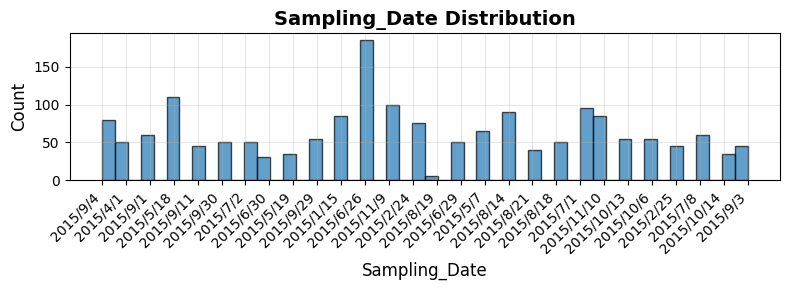

/tmp/ipykernel_39/1481063379.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout() # Adjust layout to prevent overlap


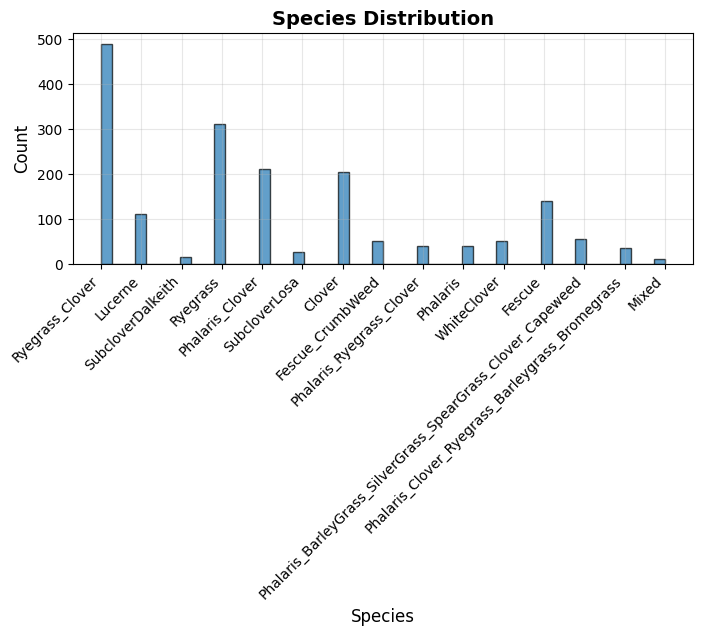

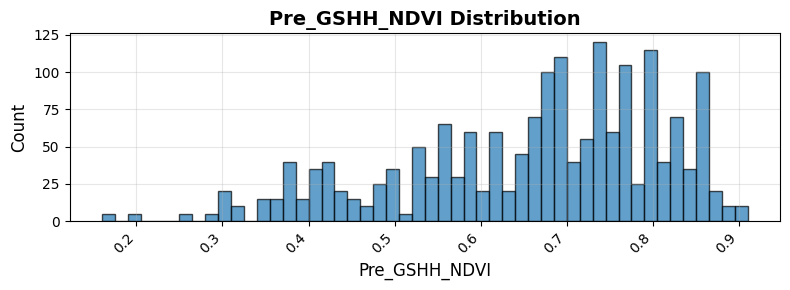

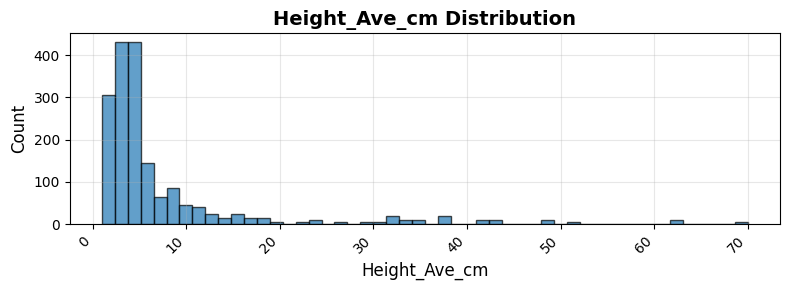

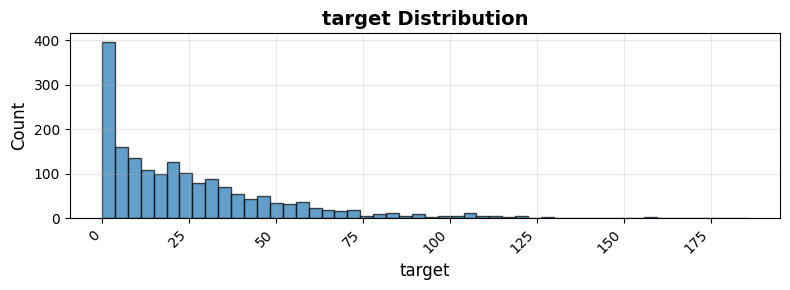

In [8]:
# Exclude non-numeric or identifier columns from histogram plotting
cols_to_plot = [col for col in TARGET_COLS if col not in ['sample_id', 'image_path', 'State', 'target_name']]

for col in cols_to_plot:
    plt.figure(figsize=(8, 3)) # Create a new figure for each histogram
    plt.hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.xticks(rotation=45, ha="right") # Rotate x-axis labels
    plt.tight_layout() # Adjust layout to prevent overlap
    plt.show()

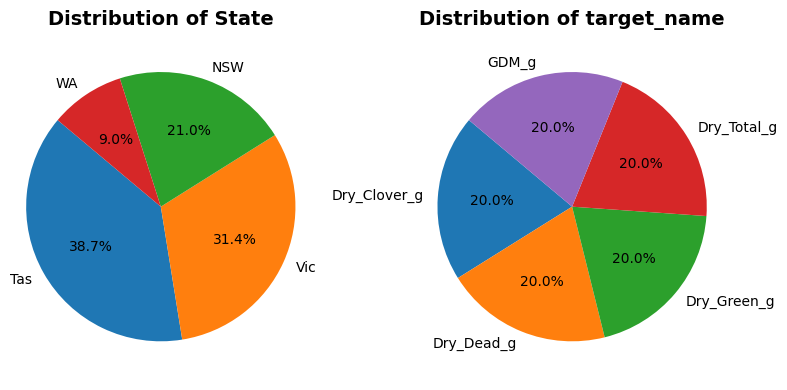

In [9]:
cols_to_plot = ['State', 'target_name']
n_rows, n_cols = 1, len(cols_to_plot)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

# Ensure axes is an array even for a single subplot
axes = axes.flatten()

for ax, col in zip(axes, cols_to_plot):
    counts = df[col].value_counts()
    ax.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140)
    ax.set_title(f'Distribution of {col}', fontsize=14, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.tight_layout()
plt.show()

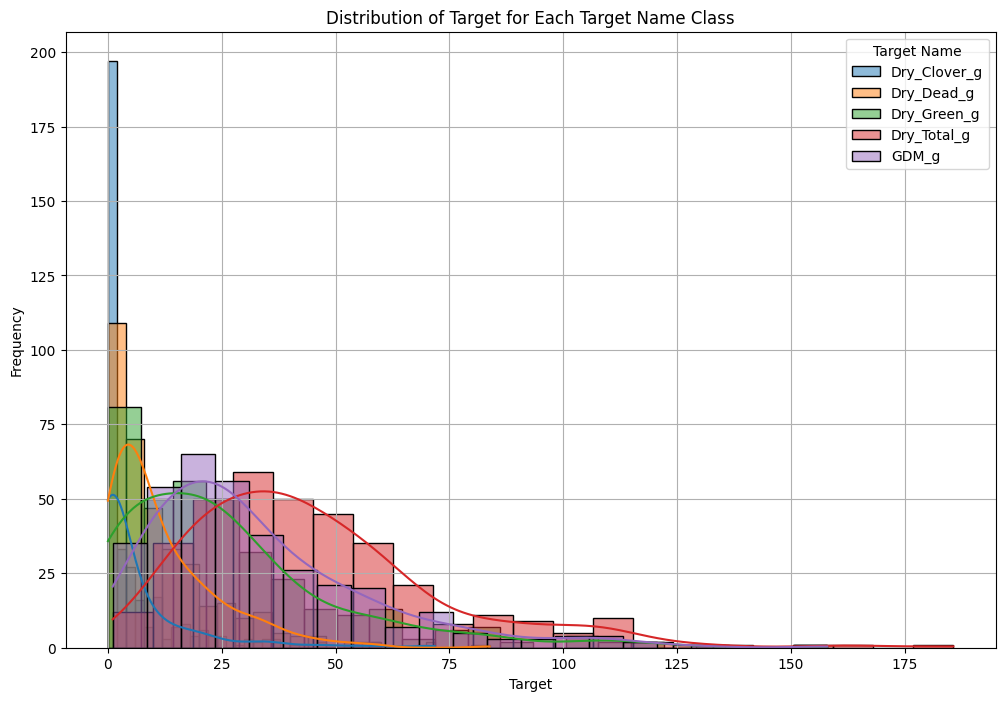

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

grouped_train_data = df.groupby('target_name')

plt.figure(figsize=(12, 8))
for target_name, group_data in grouped_train_data:
    sns.histplot(data=group_data, x='target', kde=True, label=target_name)

plt.title('Distribution of Target for Each Target Name Class')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.legend(title='Target Name')
plt.grid(True) # Added grid here
plt.show()

## Show sample images

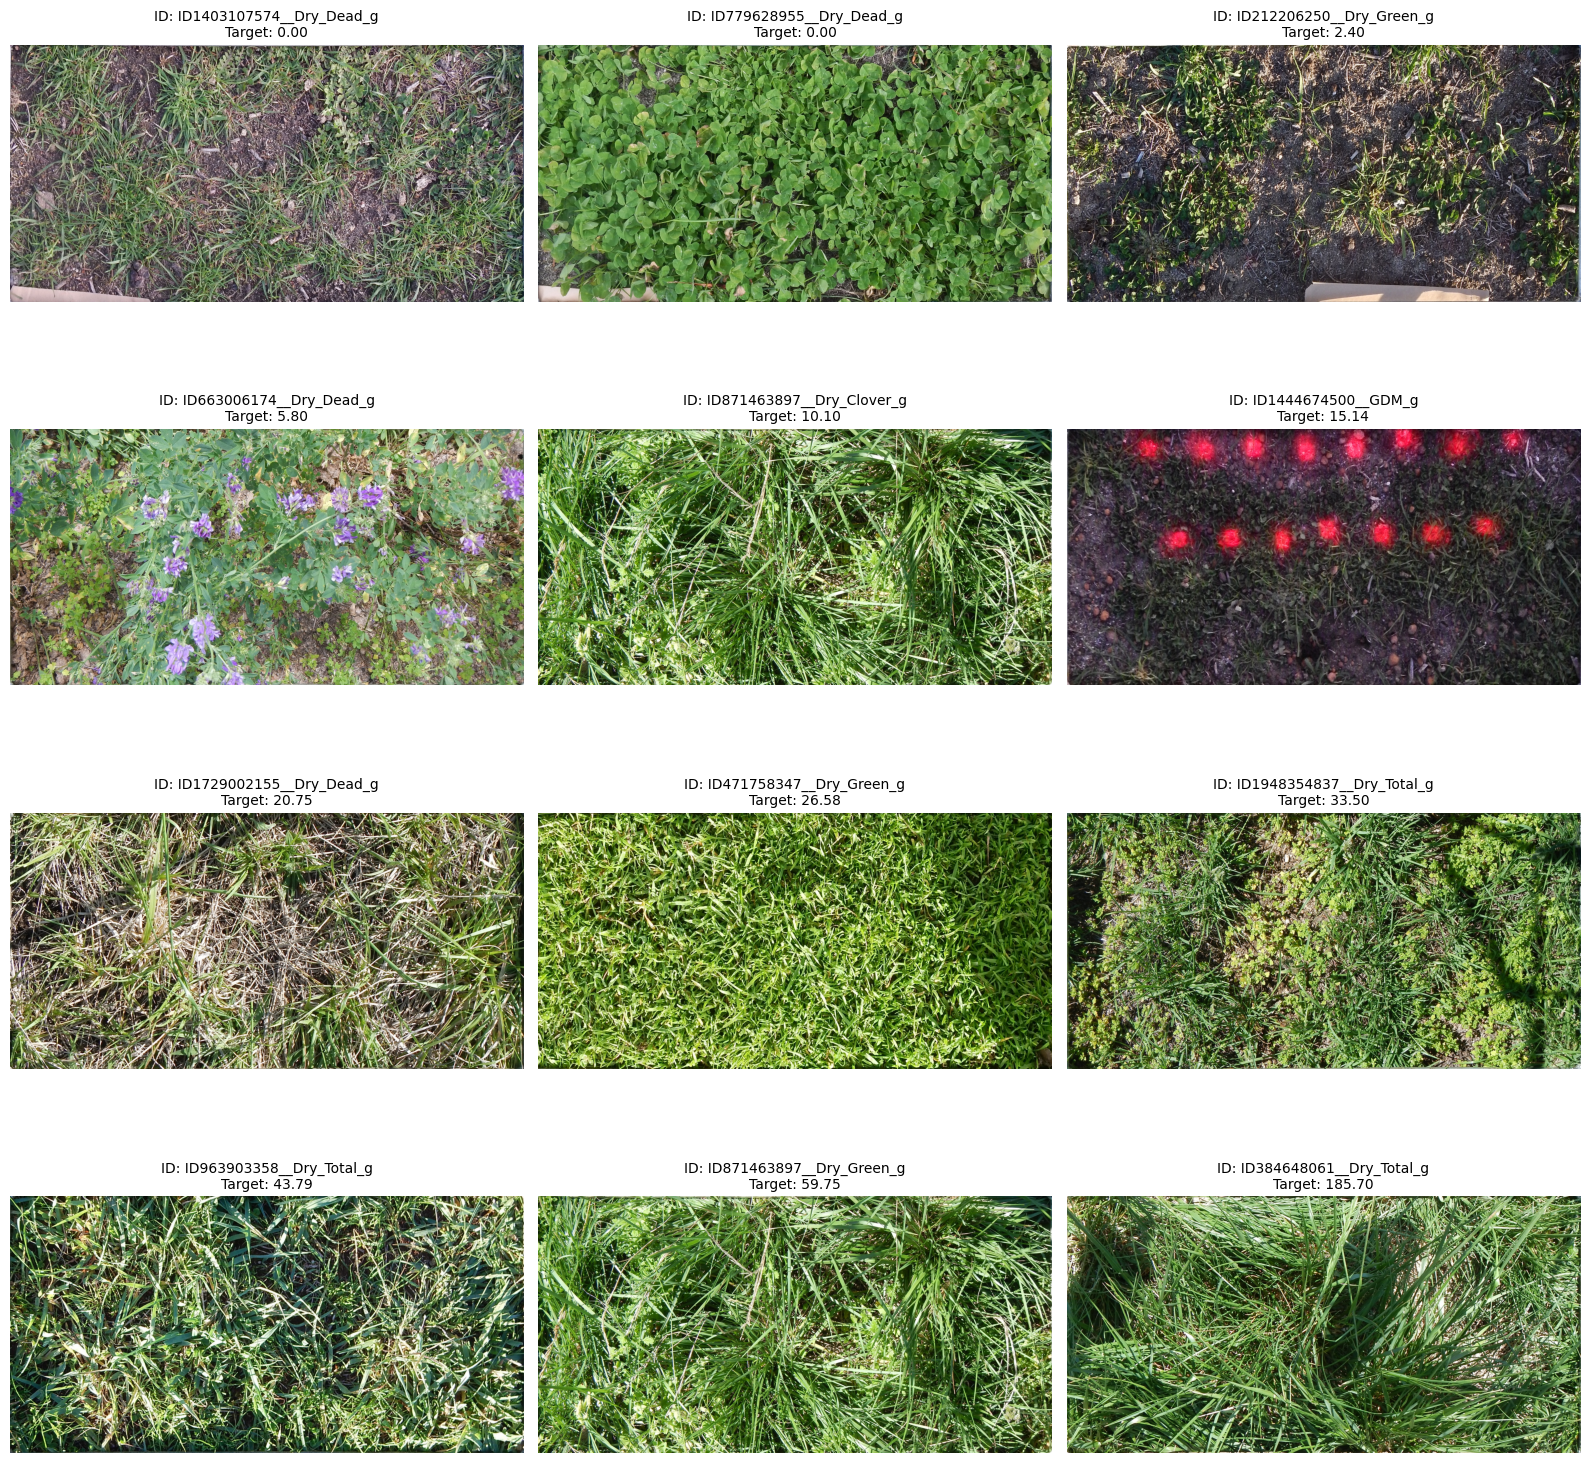

In [11]:
def show_images(df_sample, n=12, path_img=PATH_DATA):
    """Displays a linear sampling of images sorted by target value."""

    # Sort the DataFrame by the 'target' column
    df_sorted = df_sample.sort_values(by='target').reset_index(drop=True)

    # Perform linear sampling
    indices_to_show = np.linspace(0, len(df_sorted) - 1, n, dtype=int)
    df_to_show = df_sorted.iloc[indices_to_show]

    # Determine the number of rows and columns for subplots
    n_cols = 3  # You can adjust this number
    n_rows = (n + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    # Remove unused subplots if any
    for i in range(n, len(axes)):
        fig.delaxes(axes[i])

    for i, (idx, row) in enumerate(df_to_show.iterrows()):
        # Use image_path directly (includes train/ID....jpg)
        img_path = os.path.join(path_img, row['image_path'])

        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            axes[i].imshow(img)
            # Include the target value in the title
            title = f"ID: {row['sample_id']}\nTarget: {row['target']:.2f}"
            axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Example usage: Show 12 images linearly sampled based on target value
show_images(df, n=12)